In [2]:
import tensorflow as tf
import numpy as np

In [5]:
x = tf.constant([[1.,2.,3.],[4.,5.,6.]])

In [7]:
a = tf.reduce_mean(x)
b = tf.reduce_mean(x,0)
c = tf.reduce_mean(x, 1)

In [11]:
with tf.Session() as sess:
    resulta = sess.run(a)
    resultb = sess.run(b)
    resultc = sess.run(c)
    print ("a is {}, b is {}, and c is {}".format(resulta,resultb,resultc))

a is 3.5, b is [2.5 3.5 4.5], and c is [2. 5.]


In [13]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.models import Sequential

In [20]:
movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header = None, engine = 'python')

movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header = None, engine = 'python')

ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [22]:
movies_df.columns = ['MovieId', 'Name','Genres']
movies_df.head()

,MovieId,Name,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
ratings_df.columns = ['UserId', 'MovieId', 'Rating', 'Timestamp']
ratings_df.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [24]:
len(movies_df)

3883

In [26]:
# create new data frame
user_ratings_df = ratings_df.pivot(index='UserId', columns='MovieId', values='Rating')
user_ratings_df.head()

MovieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
norm_user_ratings_df = user_ratings_df.fillna(0)/5.
trX = norm_user_ratings_df.values
trX.shape

(6040, 3706)

In [38]:
visibleUnits = len(user_ratings_df.columns)
hiddenUnits = 20

vb = tf.placeholder('float', [visibleUnits])
hb = tf.placeholder('float', [hiddenUnits])
W = tf.placeholder('float', [visibleUnits,hiddenUnits])

In [43]:
# Phase 1: Forward Pass
v0 = tf.placeholder(tf.float32, [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

# Phase 2: Backward Pass (Reconstruction)
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [65]:
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(v0),h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad)/tf.to_float(tf.shape(v0)[0])
update_w = W + alpha*CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0-h1,0)

In [66]:
# error function
err = v0 - v1
error_sum = tf.reduce_mean(err*err)

In [80]:
#Initialize
curr_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
curr_vb = np.zeros([visibleUnits], np.float32)
curr_hb = np.zeros([hiddenUnits], np.float32)
prev_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
prev_vb = np.zeros([visibleUnits], np.float32)
prev_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.03960377
0.03961305
0.039635446
0.039577495
0.039563026
0.03950898
0.039555907
0.039626475
0.03950492
0.03949729
0.039462678
0.03942825
0.039549783
0.0395138
0.039449755


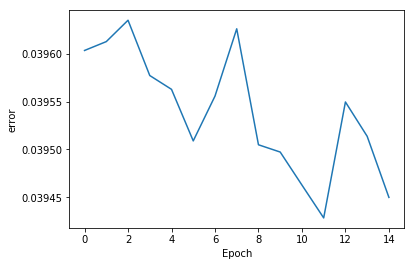

In [84]:
epochs = 15
batchsize = 100
errors = []
for epoch in range(epochs):
    for start,end in zip(range(0,len(trX),batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        curr_w = sess.run(update_w, feed_dict={v0: batch, W: prev_w, vb: prev_vb, hb: prev_hb})
        curr_vb = sess.run(update_vb, feed_dict={v0: batch, W:prev_w, vb:prev_vb,hb:prev_hb})
        curr_hb=sess.run(update_hb, feed_dict={v0: batch, W:prev_w, vb:prev_vb,hb:prev_hb})
        prev_w = curr_w
        prev_vb = curr_vb
        prev_hb = curr_hb
        
    errors.append(sess.run(error_sum, feed_dict={v0:trX, W: prev_w, vb: prev_vb, hb: prev_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('error')
plt.xlabel('Epoch')
plt.show()

In [85]:
user_id = 210

In [90]:
# select the user id
inputUser = trX[user_id-1].reshape(1,-1)
inputUser.shape

(1, 3706)

In [110]:
W.shape

TensorShape([Dimension(3706), Dimension(20)])

In [95]:
# feed the user
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0,tf.transpose(W)) + vb)

feed = sess.run(hh0, feed_dict={v0:inputUser, W:prev_w, hb:prev_hb})
rec = sess.run(vv1, feed_dict={hh0:feed, W:prev_w, vb:prev_vb})

In [109]:
df_mock = movies_df[movies_df['MovieId'].isin(user_ratings_df.columns)]
df_mock = df_mock.assign(RecommendationScore = rec[0])
df_mock.sort_values(['RecommendationScore'], ascending=False).head(50)


,MovieId,Name,Genres,RecommendationScore
453,457,"Fugitive, The (1993)",Action|Thriller,0.881450
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.865134
373,377,Speed (1994),Action|Romance|Thriller,0.860767
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.851400
724,733,"Rock, The (1996)",Action|Adventure|Thriller,0.848611
1568,1610,"Hunt for Red October, The (1990)",Action|Thriller,0.795267
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.792629
3187,3256,Patriot Games (1992),Action|Thriller,0.748726
2284,2353,Enemy of the State (1998),Action|Thriller,0.746472
1349,1370,Die Hard 2 (1990),Action|Thriller,0.724372
